In [47]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

[BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc.ru/bs4ru.html) - библиотека для парсинга HTML и XML документов

[requests](https://requests.readthedocs.io/en/latest/) - библиотека для отправки HTTP-запросов

В целом в bs4 достаточно много возможностей, с которыми лучше ознакомиться в документации по ссылке выше или в [подобных статьях](https://python-scripts.com/beautifulsoup-html-parsing), а в рамках этого ноутбука рассмотрим небольшой пример парсинга данных

### Попробуем спарсить контент первых 10 страниц Хабра



#### Для начала посмотрим на [список всех материалов](https://habr.com/ru/all)

и попробуем понять, как из каждой страницы получить ссылки на все размещенные на ней статьи.

Открыв верстку в инструментах разработчика (в хроме - F12), можно отыскать ссылки на кнопках "Читать далее", у которых есть специфичный класс - `tm-article-snippet__readmore`. 

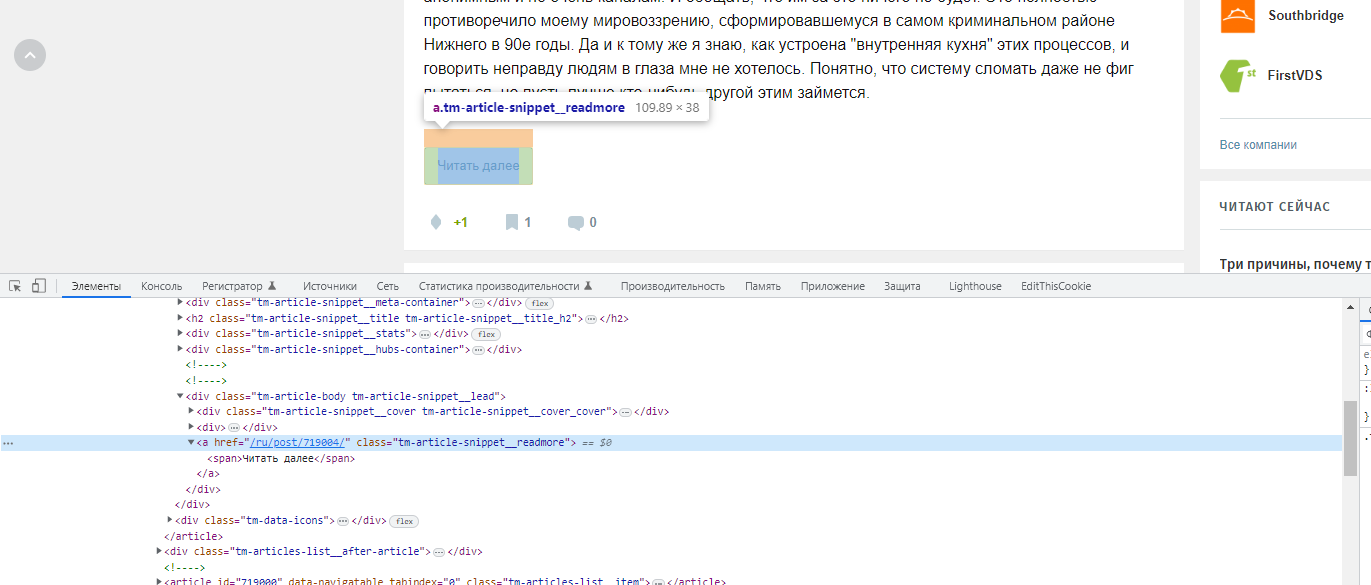

В bs4 поддерживаются [несколько типов парсеров](https://www.crummy.com/software/BeautifulSoup/bs4/doc.ru/bs4ru.html#id50)

Разные парсеры, анализируя один и того же документ создадут различные деревья HTML. Также парсеры различаются скоростью разбора HTML документа.

В данном случае будем использовать **lxml парсер**:

- Для запуска необходим установленный модуль lxml
- Быстрый, имеет внешнюю зависимость от языка C
- Нестрогий

In [17]:
base_url = 'https://habr.com/ru/all' # базовая часть ссылки, позже в цикле будем добавлять к ней пагинацию
response = requests.get('https://habr.com/ru/all/page1') # получаем контент первой страиниц
soup = BeautifulSoup(response.text, 'lxml') # инициализируем объект bs4 и задаем парсер lxml

В идеальном случае можно было бы просто вытащить со страницы все html-элементы с тегом `<a>` и нужным классом `class="tm-article-snippet__readmore"`, но при парсинге такие элементы найти не удается




In [18]:
soup.find_all('a', class_='tm-article-snippet__readmore') # ищем все a-элементы с классом tm-article-snippet__readmore

[]

Как вариант решения - можно взять ссылки для комментариев с классом `tm-article-comments-counter-link__link` вида `href="/ru/post/719004/comments/"` и убрать из них часть `comments/` 

In [15]:
raw_items = soup.find_all('a', class_='tm-article-comments-counter-link__link')  # ищем все a-элементы с классом tm-article-comments-counter-link__link
links = [item.get('href').replace('/comments', '') for item in raw_items] # получаем у ссылок только href-атрибут, убираем подстроку '/comments'
links

['/ru/post/719004/',
 '/ru/post/719000/',
 '/ru/post/718996/',
 '/ru/post/654739/',
 '/ru/post/718990/',
 '/ru/post/718992/',
 '/ru/post/718460/',
 '/ru/company/ruvds/blog/718802/',
 '/ru/post/718986/',
 '/ru/post/718978/',
 '/ru/post/718980/',
 '/ru/post/717846/',
 '/ru/post/718972/',
 '/ru/post/718970/',
 '/ru/post/718966/',
 '/ru/post/718964/',
 '/ru/company/skillfactory/blog/718894/',
 '/ru/post/718814/',
 '/ru/post/718310/',
 '/ru/post/718960/']

Теперь мы получили ссылки на 20 статей с первой страницы Хабра, осталось собрать ссылки со всех 10 страниц

In [26]:
parsed_urls = []

In [27]:
for page_num in range(1, 11):
    url = f'{base_url}/page{page_num}' # подставляем нужный номер страницы для пагинации, дальше парсим каждую страницу аналогично коду выше
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    raw_items = soup.find_all('a', class_='tm-article-comments-counter-link__link')
    parsed_urls += [item.get('href').replace('/comments', '') for item in raw_items]

In [28]:
len(parsed_urls) # 10 страниц X 20 статей

200

In [25]:
parsed_urls[35:45]

['/ru/post/718880/',
 '/ru/post/718002/',
 '/ru/company/selectel/blog/717278/',
 '/ru/post/718780/',
 '/ru/post/718890/',
 '/ru/post/718886/',
 '/ru/post/718884/',
 '/ru/post/718882/',
 '/ru/post/718876/',
 '/ru/post/718874/']

#### Пройдемся по полученным ссылкам и спарсим сами статьи

Предположим, что нам предстоит предсказывать количество голосов (votes) статьи по тексту и заголовку.

Для статьи [О «раздутом пузыре» нейросетей](https://habr.com/ru/post/718996/)

Получаем название


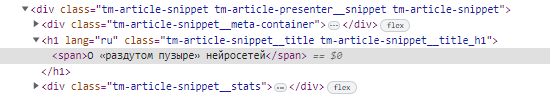

Весь текст содержится в

 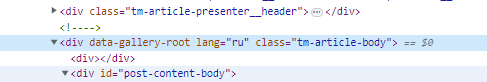

Голоса 

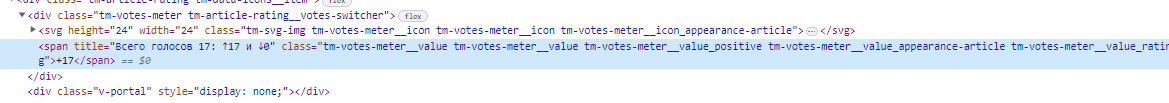

In [43]:
base_url = 'https://habr.com' # все русскоязычные материалы имеют ссылки вида https://habr.com/ru/post/718996/ 

In [39]:
#response = requests.get('https://habr.com/ru/post/718996/')
#soup = BeautifulSoup(response.text, 'lxml')
soup.find('div', class_='tm-article-body').text

" На днях я наткнулся на одно любопытное видео:Моей первой реакцией было Братан, хорош, давай, давай, вперёд! Контент в кайф, можно ещё? Вообще красавчик! Можно вот этого вот почаще? отрицание и усталость, потому что всё это я уже слышу с разной интенсивностью на протяжении лет пяти, в зависимости от текущих объектов хайпа. В этом посте я попытаюсь разобраться, что из сказанного в видео является правдой.Утверждения:Закон Мура больше не выполняется из-за фундаментальных физических ограничений ⇒ масштабирование нейросетевых моделей по вычислительному бюджету невозможно.Нейросетевые модели внедряются слишком медленно.Ответы нейросетевых моделей неконтролируемы и неинтерпретируемы.Дальше обсудим каждое из них.Сразу отмечу, что второй пункт очевидно абсурден по отношению ко всем нейросетям (распознавание лиц? машинный перевод? анализ медицинских изображений? шахматы? поисковики? контентные рекомендации и автоматическая модерация на том же YouTube?). Поэтому далее под «нейросетями» я буду по

In [48]:
result = []

for url in tqdm(parsed_urls):
    article = {}

    article_url = f'{base_url}{url}' # подставляем часть ссылки, ведущую материал
    response = requests.get(article_url)
    soup = BeautifulSoup(response.text, 'lxml')

    article['title'] = soup.find('h1', class_='tm-article-snippet__title').span.text # Получаем текст из span в первом h1 с классом tm-article-snippet__title
    article['text'] = soup.find('div', class_='tm-article-body').text # Получаем весь текст из div с классом tm-article-body
    article['votes_count'] = soup.find('span', class_='tm-votes-meter__value').text.strip('+') # Получаем текст из span с классом tm-votes-meter__value и обрезаем "+"" в начале, если есть

    result.append(article)

100%|██████████| 200/200 [05:06<00:00,  1.53s/it]


Сделаем красивый датафрейм

In [49]:
pd.set_option('display.max_colwidth', 400)

In [50]:
data = pd.DataFrame(result)
data.head()

,title,text,votes_count
0,Магия нейросетей: как математика помогает создавать искусственный интеллект,"Для обывателя слово нейросеть, в контексте машинного обучения, стало настолько затасканным и общеприменимым, что исходный смысл явления стал теряться. В мышлении обывателя нейросеть сродни чёрной коробке наполненной с одной стороны магией, с другой стороны не способная иметь внутри себя ничего неожиданного и интересного. О чем говорит такое двоемыслие в нашем восприятие - вопрос риторический....",1
1,За секунду до… Как оптоволоконные кабели могут предупредить о землетрясении,"\r\nНедавнее землетрясение магнитудой 7,8 балла в Турции и Сирии стало жестоким напоминанием о том, что глубоко внутри наша планета Земля всё ещё скрывает секреты. Учёные прекрасно знают, что активные тектонические разломы приводят к землетрясениям как результат выброса энергии во время быстрого скольжения вдоль линии разлома. Но в точности предсказать, когда произойдёт следующее сотрясение и...",3
2,Made at Intel. Специалист по этике,"Название позаимствовано у Гарри Гарриcона. Но речь у нас пойдет сегодня не о фантастике, а о намного более приземленных вещах. Всякого рода рода Ethics&Compliance кейсах, о том как они разруливаются... или не разруливаются.Как я не стал чемпионом Начну с веселого случая. В 2013-м меня только назначили GMом интелового RND в России. И прилетела к нам тем летом девочка из Израиля — Ethics&Comp...",12
3,"Пожалуйста, остановите игрострой","Я играл в компьютерные игры с 1995 года. И хотя в детстве я не раз засиживался за Civilization или TTD, я не могу считать себя заядлым геймером. За последние десять лет большую часть редкого игрового времени я потратил на Factorio. Более того, я закончил несколько франшиз, чисто для галочки.И я пришёл к выводу, что этот ваш игрострой - это полное безумие. Причём, уже конкретно поднадоевшее. У...",12
4,О «раздутом пузыре» нейросетей,"На днях я наткнулся на одно любопытное видео:Моей первой реакцией было Братан, хорош, давай, давай, вперёд! Контент в кайф, можно ещё? Вообще красавчик! Можно вот этого вот почаще? отрицание и усталость, потому что всё это я уже слышу с разной интенсивностью на протяжении лет пяти, в зависимости от текущих объектов хайпа. В этом посте я попытаюсь разобраться, что из сказанного в видео являетс...",21


Получилось неплохо, теперь можно делать дальнейшую предобработку и анализ.

В целом основная сложность парсинга в даннм случае - определить по разметке, какой элемент с какими атрибутами мы хотим вытащить из всей страницы